# Cost Projection Model From 2022 Medicare Current Beneficiary Survey - Cost Supplement

Updated 2025-09-15

Created 2025-07-07

Holland Brown [holland-reece](https://github.com/holland-reece)

### About the Dataset: 2022 MCBS - Cost Supplement
Source: https://data.cms.gov/medicare-current-beneficiary-survey-mcbs/medicare-current-beneficiary-survey-cost-supplement

- Dataset comes from Centers for Medicare & Medicaid Services (CMS)
- Contains:
    - basic demographic info on Medicare beneficiaries
    - expenditures and payment sources for co-payments, deductibles and non-covered services
    - BRR (Balanced Repeated Replication) weights --> characterize uncertainty in the survey data
- NOTE: BBR weights allow for variance estimation (and calculation of std error, CI) without accessing confidential info
- NOTE: MCBS only includes Medicare/Medicaid beneficiaries living "in the community", which means they're not living in assisted-living or other institutions (i.e. it only includes people living on their own) but it does include costs for in-home care

### About the Model Type: Gradient Boosting Decision Tree
- Gradient-boosted decision trees work well with multi-modal datasets that include some categorical variables
- There are lots of covariates in EHR data --> GB trees are good at capturing nonlinearities and interactions
- Robust to datasets with missing or incomplete data, like EHR
- Can use SHAP metrics (which are model‐agnostic) to show which features were most important to each prediction


In [ ]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm # package to display run progress
import math

import lightgbm as lgb # model type
from sklearn.metrics import root_mean_squared_error # evaluate the model
from sklearn.model_selection import train_test_split # split test/train
from sklearn.pipeline import Pipeline # K-fold cross val
import shap # Shapley additive explanations

import lightgbm as lgb



In [ ]:
# Set paths
wkdir = '/Users/hollandbrown/Desktop/cost-projection' # working dir
outdir = f'{wkdir}/results' # output directory
datadir = f'{wkdir}/MCBS-Cost-Supplement-data/CSPUF2022_Data' # raw data
raw_csv = f'{datadir}/cspuf2022.csv' # full path to raw data CSV
# raw_xpt = f'{datadir}/cspuf2022.xpt' # full path to raw data XPT

# Read CSV as pandas data and view first 10 rows
data = pd.read_csv(raw_csv)#, index_col=0) # read CSV into pandas data
# data = pd.read_sas(raw_xpt, format="xport", encoding="latin-1")
# data.head(10) # display first 10 rows of data


/var/folders/5y/qyv_j5ps5mj1t03g24ml4xwm0000gn/T/ipykernel_6003/2675708975.py:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(raw_csv)#, index_col=0) # read CSV into pandas data


In [ ]:
# Explore dataset: understand what is in the dataset, 
# how many datapoints, how many features, etc.

print(data.shape) # num rows and columns

# Print out all column names
# print(data.columns.tolist()) # list of column names 
# (horizontal comma-separated format; have to scroll right to read)

colnames = data.columns.str.replace(',', '\n').tolist() # list cols

# Read column names separated by newlines instead of commas
print_rows = 20
print_cols = math.ceil(len(colnames) / print_rows)

# Put the colnames in a grid of shape (print_rows × print_cols)
grid = [[''] * print_cols for _ in range(print_rows)]
for idx, name in enumerate(colnames):
    r = idx % print_rows
    c = idx // print_rows
    grid[r][c] = name

# Print the grid with padding in each cell to make them the same width
for row in grid:
    print("".join(f'{cell:<30}' for cell in row))


# Return number of NaNs in a specific column
print(f'CSP_NCHRNCND: {data['CSP_NCHRNCND'].isna().sum()}') # chronic conditions
print(f'CSP_INCOME: {data['CSP_INCOME'].isna().sum()}') # household income

# Return number of unique elements in a column
print(f"Unique Elems in SURVEYYR: {data['SURVEYYR'].nunique()}") # survey year
print(f"Unique Elems in CSP_AGE: {data['CSP_AGE'].nunique()}") # patient age
print(f"Unique Elems in CSP_NCHRNCND: {data['CSP_NCHRNCND'].nunique()}") # chronic conditions
print(f"Unique Elems in CSP_INCOME: {data['CSP_INCOME'].nunique()}") # household income


# Print first few elements in a column
print(data['PAMTTOT'].head(10)) # total payments from all sources 2022



# (1) Data Prep
1. Rules-based feature elimination using ML training good-practice and my EHR domain knowledge
    - remove survey year and survey version columns (same value for all rows)
    - remove patient ID numbers bc they can lead to spurious splits in the model --> overfitting
    - remove BBR replicate weights (“non-response is not a feature” principle; can leak information about sampling design)
    - remove sum of all cost, total number of treatment events, columns that are just linear combos of other columns, etc. to prevent target leakage

2. Feature encoding and test/train split
    - Since I want to use log(cost) as the model target, I will use RMSE



In [ ]:
# Rules-based feature elimination

df = data.copy() # copy dataset so I don't edit raw dataset

print(f'Original dimensions: {df.shape}')

# Rules-based feature elimination using ML training rules and my EHR domain knowledge
df.drop(index=1, columns=['PUF_ID', 'SURVEYYR', 'VERSION', 'PEVENTS'], inplace=True) # Drop duplicate data, patient IDs, total events
df.drop(columns=[c for c in df.columns if c.startswith("PAMT") and c != 'PAMTTOT'], inplace=True) # Remove payment totals cols, except grand total
df.drop(columns=[c for c in df.columns if c.startswith("CSPUF")], inplace=True) # Remove BBR weight columns
df.drop(columns=[c for c in df.columns if "AEVNTS" in c], inplace=True) # drop subtotals (causes model leakage)

print(f'New dimensions: {df.shape}')
print(df.columns)



Original dimensions: (6621, 134)
New dimensions: (6620, 6)
Index(['CSP_AGE', 'CSP_SEX', 'CSP_RACE', 'CSP_INCOME', 'CSP_NCHRNCND',
       'PAMTTOT'],
      dtype='object')


## (2) Feature Encoding and Test/Train Split
1. Split into test and train sets
    - NOTE: "Payments, All payers, Means-adjusted, Top-/bottom-coded, TOTal.” It is the sum of Medicare FFS, Medicare Advantage, Medicaid, private insurance, out-of-pocket, “other,” and write-offs; CMS has already applied ratio adjustments for MA under-reporting and the 99.5 % top-code." (from CMS MCBS Cost Supplement website)

2. Identify categorical columns
    -  There are integer categories (e.g. household income is either 1 or 2), but I can refer to the MCSB codebook to explain results at the end
    - For now, I just tell Pandas that any object or string column is categorical

In [ ]:
# Test/train split and feature encoding

# Calculate the target variable (I'm using logarithmic cost) from 
# PAMTTOT (total of all payments for all payers, mean-adjusted and top/bottom-coded)

# NOTE: np.log1p adds 1 so zeros stay finite
RAW_COST = 'PAMTTOT'
df['LOG_COST'] = np.log1p(df[RAW_COST]) # add a column with log target 

X = df.drop(columns=['LOG_COST', RAW_COST]) # keep predictors only
y = df['LOG_COST'] # set y (targets) to the calculated target vbl

# DON'T TOUCH THE HOLD-OUT SET (10% of whole dataset): Hold out a 
# test set before feat selection and everything else; 
# don't touch until the end

X_alltrain, X_holdout, y_alltrain, y_holdout = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=None
)

# Split the main training data (90% of whole dataset) into training 
# and validation sets with 80/20 split
X_train, X_val, y_train, y_val = train_test_split(
    X_alltrain, y_alltrain, test_size=0.2, random_state=42, stratify=None
)

# Identify categorical columns (later, I use mappings to make sure 
# these labels match the hold-out test dataset)

# manually add columns I know are categorical but are encoded as 
# integers in the raw dataset (from MCSB codebook)
cat_cols = ['CSP_INCOME', 'CSP_RACE', 'CSP_SEX', 'CSP_AGE', 'CSP_NCHRNCND']
for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_val[col]   = X_val[col].astype('category')
print(cat_cols)


['CSP_INCOME', 'CSP_RACE', 'CSP_SEX', 'CSP_AGE', 'CSP_NCHRNCND']


In [ ]:
# Fit LightGBM regressor

# Set params
# Keeping in mind that I plan to use log(cost) as the model target...

 # NOTE: use root mean sq error bc I'm using log(cost) as the model 
 # target (alternatively, could use tweedie if target was raw cost)
params = dict(
    objective='rmse',
    learning_rate=0.05,
    n_estimators=2000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Now fit the regressor

# NOTE: # early stopping is a regularization technique to prevent
# overfitting (model will stop after 100 iterations if no RMSE 
# improvement)
gbdt = lgb.LGBMRegressor(**params)
gbdt.fit(
    X_train, y_train,
    categorical_feature=cat_cols,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[
        lgb.early_stopping(stopping_rounds=40)
        ]
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22
[LightGBM] [Info] Number of data points in the train set: 4766, number of used features: 5
[LightGBM] [Info] Start training from score 8.782271
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, n_estimators=2000,
              objective='rmse', random_state=42, subsample=0.8)

In [ ]:
# Test with Hold-out Dataset

# Make sure the columns are in identical order
X_holdout = X_holdout[X_train.columns]

# Cast every categorical column to the same categorical dtype so holdout and training categories match
for col in cat_cols:
    X_holdout[col] = pd.Categorical(
        X_holdout[col],
        categories=X_train[col].cat.categories # guarantees identical mapping
    )

# Calculate TRUE LOSS and compare to training loss (best RMSE from 
# validation during training)
y_holdout_log = gbdt.predict(X_holdout, num_iteration=gbdt.best_iteration_)

# bias-correction; smear calculated from training residuals
smear = np.exp((y_train - gbdt.predict(X_train)).mean())
y_pred_dollars = np.expm1(y_holdout_log) * smear
log_rmse_hold  = root_mean_squared_error(y_holdout, y_holdout_log)

# Convert log-cost back to dollars and calculate RMSE to get the true 
# loss (compare to training loss)
pred_rmse_dollars = root_mean_squared_error(np.expm1(y_holdout), y_pred_dollars)

# Now get log RMSE and RMSE in dollars for training loss for comparison
y_train_log = gbdt.predict(X_train, num_iteration=gbdt.best_iteration_)
y_train_dollars = np.expm1(y_train_log) * smear
log_rmse_train = root_mean_squared_error(y_train, y_train_log)
train_rmse_dollars = root_mean_squared_error(np.expm1(y_train), y_train_dollars)


# print(f'True Loss: ${pred_rmse_dollars:.2f}') # true RMSE loss in 
# dollars; format number of decimal places

# Format output as a table
print(f"Log-RMSE       | train: {log_rmse_train:.3f}         test: {log_rmse_hold:.3f}")
print(f"RMSE ($)       | train: ${train_rmse_dollars:,.2f}    test: ${pred_rmse_dollars:,.2f}")


Log-RMSE       | train: 1.475         test: 1.407
RMSE ($)       | train: $32,021.33    test: $31,990.35


## Visualize the Tree and Important Features

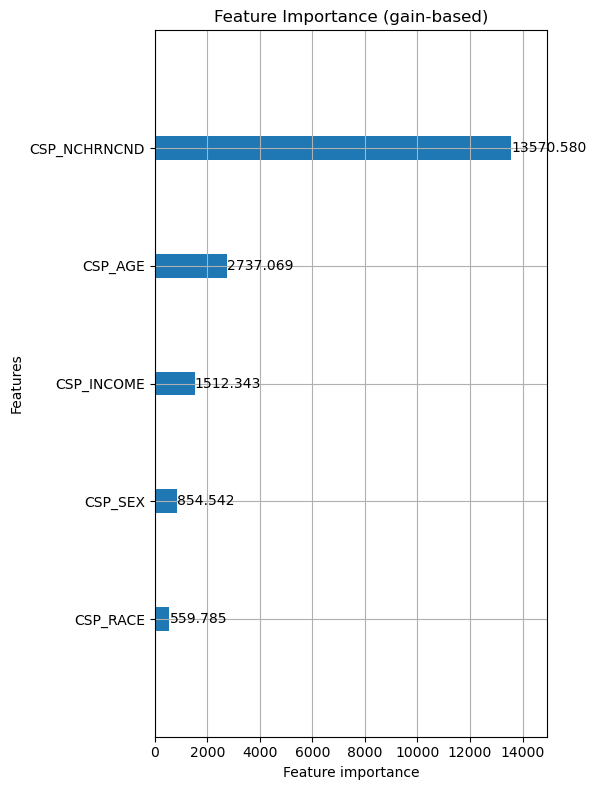

In [ ]:
# Visualize the Tree and Important Features

# Feat importance (gain-based)
# NOTE: Gain is the total reduction in loss the feat brings across all 
# splits, where splits are times the feature was chosen by the tree
ax = lgb.plot_importance(
        gbdt, # fitted LGBMRegressor
        importance_type="gain", # or "split" for frequency
        figsize=(6, 8)
)
ax.set_title("Feature Importance (gain-based)")
plt.tight_layout()
plt.show()



## Shapley Additive Explanations

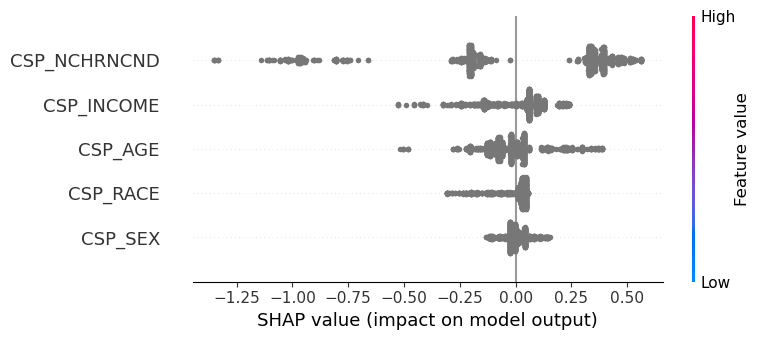

In [ ]:
explainer = shap.TreeExplainer(gbdt)
shap_values = explainer.shap_values(X_val, check_additivity=False)

shap.summary_plot(
        shap_values, X_val,
        plot_type="dot",            # swarm of dots
        max_display=20,             # top-20 features
        show=True
)
